In [ ]:
import numpy as np
import matplotlib.pyplot as plt


##1D FDTD solver
# curlE = -mu. dh/dt
#curlH = J + epsilon.dE/dt
#need half time steps and whole time steps for E and H alternatively
#1D --curl equations in 1D only with Ex and Hz
#staggered Yee grid

class constants_class:
    def __init__(self):
        self.mu0 = 1.25*10**-6
        self.e0 = 8.85*10**-12
        self.c0 = 1 /np.sqrt(self.e0 * self.mu0)
        self.imp = np.sqrt( self.mu0 / self.e0)
const = constants_class()

jmax, nmax = 500, 2000

dx, dt = 1, 1 

E_field = np.ones(jmax) ; H_field = np.ones(jmax-1)





In [12]:
import numpy as np
import matplotlib.pyplot as plt
import tqdm
from matplotlib.animation import FuncAnimation

# Usage:
# fdtd = fdtd1d()
# fdtd.run()
# fdtd.plot()

class fdtd1d(object):
    def __init__(self, Nx = 201, dx = 1e-3, c = 1, source = 100):
        # Grid properties:
        # 1. Number of grid cells
        self.Nx = Nx
        # 2. Grid cell size
        self.dx = dx
        # 3. Speed of light
        self.c = c
        # 4. Time step size (obeying Courant number)
        self.dt = dx / (1.0 * self.c)

        # Source properties:
        # 1. Source location array index
        self.source = source
        # 2. Source frequency, period etc.:
        frequency = 1 / (self.dt * 10)
        T0 = 1.0 / frequency
        tc = 5 * T0 / 2
        self.sig = tc / 2 / np.sqrt(2 * np.log(2))

        # Initialize grid:
        # 1. Electric field grid
        self.E_y = np.zeros(Nx)
        # 2. Magnetic field grid
        self.H_z = np.zeros(Nx - 1) 

        # Mur absorbing boundary conditions (ABC)
        # ABC for right side 
        self.E_y_h = 0 
        # ABC for left side
        self.E_y_l = 0

        # Record the time dependent electric field.
        self.E_t = []
        
        # Physical grid for plotting
        self.x = np.arange(0, Nx, 1)
        self.Dx = np.arange(0.5, Nx-0.5, 1)

    def run(self, n_iter = 180):
        # Main FDTD Loops
        dt = self.dt
        dx = self.dx
        c = self.c
        sig = self.sig
        source = self.source
        
        for n in tqdm.trange(n_iter):
            # Update magnetic field
            self.H_z = self.H_z - dt / dx * (self.E_y[1:] - self.E_y[:-1])     

            # Update electric field
            self.E_y[1:-1] = self.E_y[1:-1] - dt / dx * (self.H_z[1:] - self.H_z[:-1])
        
            # Initiate source to start the simulation
            pulse = np.exp((-((n+1) * dt - 3 * np.sqrt(2) * sig)**2) / (2 * sig**2))
            self.E_y[source] = self.E_y[source] + pulse
         
            # Absorbing boundary condition for right side of grid
            self.E_y[-1] = self.E_y_h + (c * dt - dx) / (c * dt + dx) * (self.E_y[-2] - self.E_y[-1])
            self.E_y_h = self.E_y[-2]
    
            # Absorbing boundary condition for left side of grid
            self.E_y[0] = self.E_y_l + (c * dt - dx) / (c * dt + dx) * (self.E_y[1] - self.E_y[0])
            self.E_y_l = self.E_y[1]
            
            self.E_t.append(self.E_y.copy())
        
    def plot(self):
        # plot the E_y and H_z fields in space
        plt.figure(figsize = (10, 5))
        plt.subplot(2, 1, 1)
        plt.plot(self.x, self.E_y)
        plt.ylabel("E_y")
        plt.grid(True)
        plt.subplot(2, 1, 2)
        plt.plot(self.Dx, self.H_z, color = (0.1,0.1,0.2))
        plt.ylabel("H_x")
        plt.grid('on')
        plt.xlabel("x")
        plt.show()
        
    def animate(self, file_dir = "fdtd_1d_animation.gif", N = 500):
        # animate self.Et as a .gif file.
        # N: number of total steps to save as .gif animation.
        Et = self.E_t[-N:]
        
        fig, ax = plt.subplots()
        ax.set(xlim = [-10, 210], ylim = [-1, 1])
        line = ax.plot(range(len(Et[0])), Et[0], color = "r", linewidth = 2)[0]
        ax.set_xlabel("x")
        ax.set_ylabel("Electric field")
        ax.grid(True)

        def animate(i):
            line.set_ydata(Et[i])

        anim = FuncAnimation(fig, animate, interval = 50, frames = len(Et) - 1)
        anim.save(file_dir, writer = "pillow") 
        plt.show()

100%|██████████| 80/80 [00:00<00:00, 21241.02it/s]


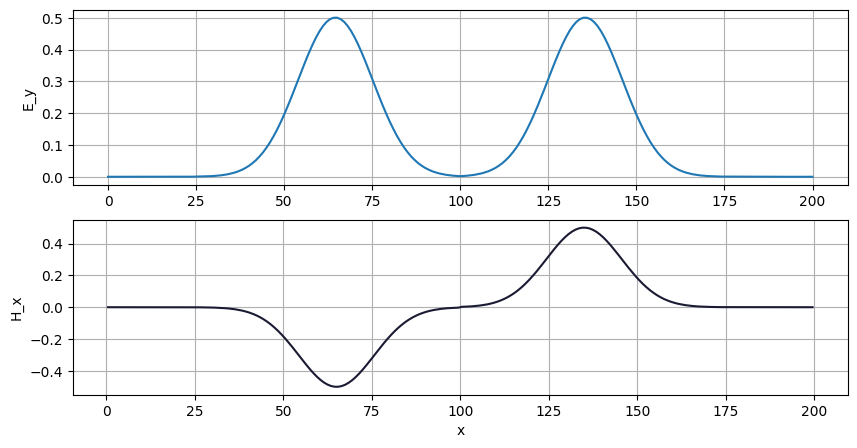

In [13]:
fdtd = fdtd1d() # Create simulator. 
fdtd.run(80) # Execute simulation for 80 time steps.
fdtd.plot() # Plot the electric and magnetic fields.